# Imports

In [1]:
from fastai.vision.all import *
import wandb
from fastai.callback.wandb import *

KeyboardInterrupt: 

In [ ]:
wandb.login()

# Load Data

In [3]:
path = Path('~/data/melanoma-kaggle'); path.ls()

(#5) [Path('/storage/data/kaggle-melanoma/siim-isic-melanoma-classification.zip'),Path('/storage/data/kaggle-melanoma/train.csv'),Path('/storage/data/kaggle-melanoma/sample_submission.csv'),Path('/storage/data/kaggle-melanoma/test.csv'),Path('/storage/data/kaggle-melanoma/jpeg')]

In [4]:
path_images = path/'train'
path_images.ls()

(#33126) [Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_5990639.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_8654660.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_3899323.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_4618918.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_2429070.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_5069715.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_0283541.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_2945324.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_9613570.jpg'),Path('/storage/data/kaggle-melanoma/jpeg/train/ISIC_7185913.jpg')...]

## EDA

In [5]:
df_train = pd.read_csv(path/'train.csv');  len(df_train)

33126

In [6]:
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [7]:
df_train.describe(include='all')

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
count,33126,33126,33061,33058.000000,32599,33126,33126,33126.000000
unique,33126,2056,2,NaN,6,9,2,NaN
top,ISIC_0641480,IP_4382720,male,NaN,torso,unknown,benign,NaN
freq,1,115,17080,NaN,16845,27124,32542,NaN
mean,NaN,NaN,NaN,48.870016,NaN,NaN,NaN,0.017630
std,NaN,NaN,NaN,14.380360,NaN,NaN,NaN,0.131603
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,40.000000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,60.000000,NaN,NaN,NaN,0.000000


In [8]:
33126*0.0176

583.0176

Interesting, the classes are very unbalanced, much more benign than malignant.

### Ideas about tabular data
- Explore correlation between features and targets
    - Ex: sex, age, anatom_site (these are the only ones provided in test data)
- Find a way to factor these into model
    - Initial idea: Compute detection features, concat w/sex, age, and anatom_site and pass to FC layer
    - Future ideas: 
        - Maybe create context vector that includes features of patient's other moles, each with anatom_sit added
        - Add sex and age to feature vector too

In [9]:
df_test = pd.read_csv(path/'test.csv'); len(df_test)

10982

In [10]:
df_test.head();

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [11]:
df_test.describe(include='all');

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
count,10982,10982,10982,10982.000000,10631
unique,10982,690,2,NaN,6
top,ISIC_5050453,IP_3579794,male,NaN,torso
freq,1,240,6255,NaN,5847
mean,NaN,NaN,NaN,49.525587,NaN
std,NaN,NaN,NaN,14.370589,NaN
min,NaN,NaN,NaN,10.000000,NaN
25%,NaN,NaN,NaN,40.000000,NaN
50%,NaN,NaN,NaN,50.000000,NaN
75%,NaN,NaN,NaN,60.000000,NaN


## Look at individual images

<AxesSubplot:>

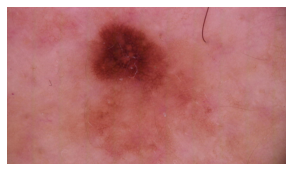

In [12]:
f = get_dicom_files(path_images)[0]
img = PILDicom.create(f)
img.show()

In [ ]:
f.dcmread()

In [13]:
f.stem

'ISIC_5990639'

## Build DataBlock

Idea: To model test set, split train/val by patient ID.

In [ ]:
data = DataBlock()
data.datasets(df_train).train[0]

In [ ]:
def get_x(r): return path_images/f'{str(r['image_name'])}.dcm'
def get_y(r): return r['benign_malignant']

In [ ]:
data = DataBlock(get_x=get_x, get_y=get_y)
data.datasets(df_train).train[0]

In [ ]:
vocab = {'benign': 0, 'malignant': 1}

In [ ]:
data = DataBlock(blocks=(ImageBlock, CategoryBlock(vocab=vocab)),
                get_x=get_x, get_y=get_y)
data.datasets(df_train).train[0]

In [ ]:
patient_ids = df_train['patient_id'].unique().to_array()
patient_ids.shape

In [ ]:
iteration_idxs = np.random.choice(np.arange(len(patient_ids)), 200, replace=False)
iteration_idxs

In [ ]:
# split by patient id. Also, allow for creation of smaller iteration set.
def patient_id_splitter(df, num_train=None, num_valid=None):
    patient_ids =
    return train, valid

## Build Dataloaders

## Look at processed data

# Modeling

In [45]:
wandb.init(project='melanoma-classification')

W&B Run: https://app.wandb.ai/bwolfson97/melanoma-classification/runs/3baa6n9k

## Create learner

In [46]:
learn = cnn_learner(dls, resnet18, metrics=RocAucBinary(), cbs=WandbCallback(log_model=False))

## Get fine_tune baseline

## LR Finder

## Train head

## Unfreeze & Find new LR

## Train entire model w/discriminative LR

# Analysis

In [ ]:
interp = ClassificationInterpreter.from_learner(learn)

## Confusion matrix

In [ ]:
interp.plot_confusion_matrix()

## Top Losses

In [ ]:
interp.plot_top_losses()

## Clean up dataset??

# Submit

## Generate predictions

## Format correctly

## Write to CSV

## Submit! :)